# Goal: Explore DC bike data to understand the demand for bicycle rentals over time and fit a regression line to the data.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.linear_model import LinearRegression

In [4]:
# 1. Read in data:
df = pd.read_csv('./data/dc_bikes.csv', parse_dates=True)

In [5]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
# 2. What is the average temperature in summer?
df_seasons = df.groupby("season")["temp"].mean()

In [7]:
df_seasons

season
1    12.530491
2    22.823483
3    28.789111
4    16.649239
Name: temp, dtype: float64

In [8]:
#converting the column to timestamp

df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'].index

RangeIndex(start=0, stop=10886, step=1)

In [9]:
df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [10]:
# extracting hour,month and year from the column datetime
df['hour']  = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month_name()
df['month_number'] = df['datetime'].dt.month
df['year']  = df['datetime'].dt.year

In [11]:
# create the column part of the day based on labels and boundaries
bin_labels = ['night','morning', 'afternoon', 'evening']
bin_boundaries = [-1,6, 12, 17, 23] 
df['part_of_day']=pd.cut(df['hour'], bins=bin_boundaries, labels=bin_labels)

In [12]:
# observed grouped means
df_part_of_day = df.groupby(["hour", "part_of_day"])["temp"].mean()
df_part_of_day

hour  part_of_day
0     night          19.013187
      morning              NaN
      afternoon            NaN
      evening              NaN
1     night          18.639648
                       ...    
22    evening        19.766316
23    night                NaN
      morning              NaN
      afternoon            NaN
      evening        19.343728
Name: temp, Length: 96, dtype: float64

In [13]:
#Pivot Table
df.pivot_table(values='registered', 
                      columns=['workingday','part_of_day'], 
                      aggfunc='sum')

workingday       0                                1                          
part_of_day  night morning afternoon evening  night morning afternoon evening
registered   33015  132209    169314  114297  55187  414673    361226  413420

In [14]:
# create a new dataframe with a subset of column of the original dataframe
new_df = df[["temp", "atemp","humidity","windspeed","count"]]

In [15]:
# looks like temperature and atemp are more correlated with count
corr_df = new_df.corr()

In [16]:
corr_df

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


<AxesSubplot:>

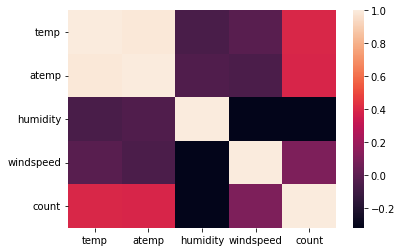

In [18]:
sns.heatmap(corr_df)

In [19]:
df_temp_count = new_df[["temp","count"]]

In [20]:
m = LinearRegression()
temp = df[["temp"]]
count = df["count"]
m.fit(temp,count)

LinearRegression()

In [21]:
#looks like there is no strong relation between temperature and count
m.score(temp,count)

0.15559367802794855

In [22]:
#doing the regression only for weekends, maybe the temperature influences the bicycle cout more during the weekend
# because when its used as a transport the temperature will not influence, but when used for fun it will
# create a dataframe subset only with lines where working days = 0(weekends)
#create first a boleen mask and then apply the mask using df.loc()

working_days_filter = df['workingday'] == 0
new_df2 = df.loc[working_days_filter]

weekend_df = new_df2[["temp", "atemp","humidity","windspeed","count"]]
corr1 = weekend_df.corr()
corr1

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.992755,-0.066298,-0.042971,0.504788
atemp,0.992755,1.000000,-0.043701,-0.082044,0.502562
humidity,-0.066298,-0.043701,1.000000,-0.356906,-0.425693
windspeed,-0.042971,-0.082044,-0.356906,1.000000,0.110578
count,0.504788,0.502562,-0.425693,0.110578,1.000000


In [23]:
df_temp_count1 = weekend_df[["temp","windspeed", "humidity", "count"]]

In [24]:
m1 = LinearRegression()
temp_x = df_temp_count1[["temp", "windspeed", "humidity"]]
count_y = df_temp_count1["count"]
m1.fit(temp_x,count_y)
m1.score(temp_x,count_y)

0.4094353432180804

In [25]:
y_pred = m1.predict(temp_x)